In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

from pathlib import Path
pd.options.plotting.backend = "plotly"
pd.set_option('display.max_columns', None)


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_X = pd.read_csv('../data/train_values.csv', index_col='building_id')
train_y = pd.read_csv('../data/train_labels.csv', index_col='building_id')

X_test = pd.read_csv('../data/test_values.csv', index_col='building_id')

In [3]:
train_X[['geo_level_1_id','geo_level_2_id','geo_level_3_id']] = train_X[['geo_level_1_id','geo_level_2_id','geo_level_3_id']].astype(str)
X_test[['geo_level_1_id','geo_level_2_id','geo_level_3_id']] = X_test[['geo_level_1_id','geo_level_2_id','geo_level_3_id']].astype(str)

train_X[['count_floors_pre_eq','age','area_percentage','height_percentage']] = train_X[['count_floors_pre_eq','age','area_percentage','height_percentage']].astype(float)

train_X['volume_percentage']=train_X['area_percentage'] * train_X['height_percentage']
X_test['volume_percentage']=X_test['area_percentage'] * X_test['height_percentage']

# Categorical columns 
categorical_columns = [c for c in train_X.select_dtypes(include=['object'])]
numerical_columns= list(set(train_X.columns) - set(categorical_columns))

In [4]:
# Drop building_id (index) from X and y
train_X.reset_index(drop=True, inplace=True)
train_y.reset_index(drop=True, inplace=True)

In [5]:
duplicate_index_mask = train_X.index.duplicated(keep='first')
X = train_X[~duplicate_index_mask]
y = train_y[~duplicate_index_mask]

## split the data

In [6]:
def scaler(n):
    if n == 1:
        return 0
    if n>1:
        return 1

In [7]:
y["binary_damage"] = y["damage_grade"].apply(scaler)
new_y = y.drop(columns="damage_grade")
new_y.head(10)

,binary_damage
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,0
8,1
9,0


In [9]:
from sklearn.model_selection import train_test_split
binary_X_train, binary_X_valid, binary_y_train, binary_y_valid = train_test_split(X, new_y, test_size=0.2, random_state=0)

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import TargetEncoder


# Preprocessing categorical data
categorical_transformer = Pipeline(steps=[
    ("target", TargetEncoder(target_type="continuous"))
])

# Bundle prepocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_columns),
        ("numerical", "passthrough", numerical_columns),
    ])

In [12]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=300, max_depth=100, random_state=57)

clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model)
]
)

clf.fit(binary_X_train, binary_y_train["binary_damage"])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('target',
                                                                   TargetEncoder(target_type='continuous'))]),
                                                  ['geo_level_1_id',
                                                   'geo_level_2_id',
                                                   'geo_level_3_id',
                                                   'land_surface_condition',
                                                   'foundation_type',
                                                   'roof_type',
                                                   'ground_floor_type',
                                                   'other_floor_type',
                                                   'position',
                                                   'plan_configuration',
                                                   'legal_ownership_status']),
                                                 ('num...
                                                   'has_superstructure_cement_mortar_stone',
                                                   'has_superstructure_bamboo',
                                                   'has_superstructure_cement_mortar_brick',
                                                   'has_secondary_use_health_post',
                                                   'has_secondary_use_industry',
                                                   'has_secondary_use',
                                                   'has_secondary_use_use_police',
                                                   'has_superstructure_mud_mortar_brick',
                                                   'has_secondary_use_institution'])])),
                ('model',
                 RandomForestClassifier(max_depth=100, n_estimators=300,
                                        random_state=57))])

In [13]:
from sklearn.metrics import f1_score

binary_pred_valid = clf.predict(binary_X_valid)

binary_f1_score = f1_score(binary_y_valid, binary_pred_valid, average='micro')

print(f"F1 score: {binary_f1_score}")

F1 score: 0.9311218127050517


In [15]:
import plotly.graph_objects as go

# Extract feature importances from the random forest model
feature_importances = clf.named_steps['model'].feature_importances_

# Combine feature importances with their corresponding feature names
# This requires a bit of manipulation since you have a ColumnTransformer
# Assuming 'categorical_columns' and 'numerical_columns' are lists of feature names
features = categorical_columns + numerical_columns
sorted_idx = feature_importances.argsort()

# Create a bar plot
fig = go.Figure([go.Bar(x=feature_importances[sorted_idx], y=[features[i] for i in sorted_idx], orientation='h')])

# Update layout
fig.update_layout(title='Feature Importances in Random Forest Model',
                  xaxis_title='Importance',
                  yaxis_title='Feature',
                  yaxis={'categoryorder':'total ascending'},
                  height=600, width=800)

# Show the plot
fig.show()


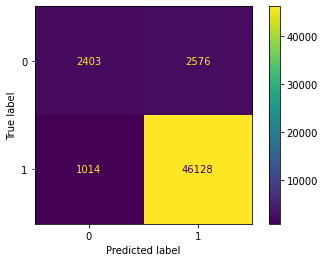

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(clf, binary_X_valid, binary_y_valid)

## Split the original data into two based on the predictions of the first model

# Use Model 1 to make predictions on the training data


In [17]:
model1_predictions_train = clf.predict(binary_X_train)
model1_predictions_train

array([1, 0, 0, ..., 1, 1, 1])

## Creating data for the second model

In [18]:
X_train_model_2 = binary_X_train[model1_predictions_train != 0]
y_train_model_2 = binary_y_train[model1_predictions_train != 0]

# Ensure y_train_model_2 only contains classes 1 and 2
y_train_model_2 = y_train_model_2[y_train_model_2 != 0]


In [19]:
X_train_model_2.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,volume_percentage
5654,20,281,7097,2.0,15.0,6.0,7.0,t,r,q,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0,42.0
53449,13,1372,4555,2.0,10.0,6.0,5.0,t,r,n,f,q,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,30.0
202567,8,206,6064,3.0,35.0,6.0,5.0,t,r,q,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0,30.0
121734,10,1074,1601,2.0,25.0,6.0,5.0,t,r,n,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,0,0,0,0,0,0,0,0,0,0,0,0,30.0
238675,4,616,3475,2.0,15.0,5.0,4.0,t,r,q,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,20.0


In [20]:
y_train_model_2.head()

,binary_damage
5654,NaN
53449,1.0
202567,1.0
121734,1.0
238675,1.0


In [22]:
binary_y_train.iloc

,binary_damage
59043,1
70217,1
18955,1
51117,1
238349,1
63006,1
116886,1
125350,1
19469,1
102672,1
